# MSc in AI - CE6002 & CS5062


# E-tivity 4: Overfitting & How to Prevent It
# CS5062 - Performance of Classifiers - Tasks 1, 2 and 3

## Student Name: Mark Murnane
## Student ID: 18195326
-----

### Imports and Additional Functions

The following imports are taken from the provided examples.

#### Task 2 Modification

Added import for `precision_score` and `recall_score`.

#### Task 3 Modification

Added import for `GridSearchCV`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from itertools import cycle

from sklearn import preprocessing
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

from sklearn.model_selection import GridSearchCV

from scipy import interp

Load Nik's provided functions for evaluation and plotting.

In [2]:
%run ./Lab4_Functions_18195326.ipynb

Also want to suppress any FutureWarnings generated by scikit-learn.

In [3]:
# Don't want FutureWarnings from scikit-learn while running Cross-Validation
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

# Task 1

This task repeats the training and evaluation of SVM and Naive Bayes classifiers found in *Lab 4 - Comparison of Classifiers - Main* but this time on the *loans_et4.csv* dataset.

Additionally, a third classification algorithm from scikit-learn should be trained and evaluated.  Any algorithm other than SVM or Naive Bayes can be used.

Finally a summary of the conclusions will be provided.

-----

## Data Load

In [4]:
df = pd.read_csv("./loans_et4.csv")
df.describe()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
count,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000,480.000000
mean,0.820833,0.647917,0.777083,0.797917,0.137500,5364.231250,1581.093583,144.735417,342.050000,0.854167,1.022917,0.691667
std,0.383892,0.478118,1.020815,0.401973,0.344734,5668.251251,2617.692267,80.508164,65.212401,0.353307,0.776411,0.462287
min,0.000000,0.000000,0.000000,0.000000,0.000000,150.000000,0.000000,9.000000,36.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,1.000000,0.000000,2898.750000,0.000000,100.000000,360.000000,1.000000,0.000000,0.000000
50%,1.000000,1.000000,0.000000,1.000000,0.000000,3859.000000,1084.500000,128.000000,360.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,2.000000,1.000000,0.000000,5852.500000,2253.250000,170.000000,360.000000,1.000000,2.000000,1.000000
max,1.000000,1.000000,3.000000,1.000000,1.000000,81000.000000,33837.000000,600.000000,480.000000,1.000000,2.000000,1.000000


In [5]:
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,0,0,0,1,0,2378,0.0,46,360,1,0,0
1,0,0,0,1,0,5000,2541.0,151,480,1,0,0
2,0,0,0,1,0,10000,1666.0,225,360,1,0,0
3,1,0,0,1,0,6500,0.0,105,360,0,0,0
4,1,0,0,1,0,1853,2840.0,114,360,1,0,0


The data set consists of all numeric attributes.  There are no missing values.

The target attribute is *Loan_Status*.  As per Nik's comment in the Q&A Session on March 11th, no specific EDA is required for this E-tivity.

As it's important to understand the target attribute distribution for Cross-Validation and also choosing ROC vs. Precision-Recall Curve's, we'll determine the unique counts of *Loan_Status*.

In [6]:
df['Loan_Status'].value_counts()

1    332
0    148
Name: Loan_Status, dtype: int64

In [7]:
print(f"The first occurence of Loan_Status = 1 occurs at row {df['Loan_Status'].idxmin()}")

The first occurence of Loan_Status = 1 occurs at row 0


The counts show that dataset is split 30.83%/69.16% for *Loan_Status* = 0/1.  This result suggests two things:

 - When using cross-validation the training and validation sets should be stratified to ensure they remain balanced with respect to the original data.  Nik's use of `StratifiedKFold` does this.
 - Precision-Recall metrics may be give a more accurate representation of model efficiency.  For unbalanced targets such as this, ROC curves may be over optimistic about model performance.

The data in the file is also sorted by *Loan_Status* so need to be sure to shuffle the data set.

-----

To keep things simple later and following Nik's lead split, the data frame into *predictor* attributes and the *target* attribute.  These will be stored as numpy arrays.

In [8]:
# Extract that target attribute first
target = df['Loan_Status'].values

# Extract the predictors
predictors = df.drop('Loan_Status', axis=1).values

# Scale the Predictors to range [0, 1]
# Target value is already in range [0 1]
min_max_scaler = preprocessing.MinMaxScaler()
predictors = min_max_scaler.fit_transform(predictors)

## Classification Training

### Create scale for graphs

To ensure graphs are uniform create a consistent (and full) range of False-Positive Rate (fpr) values between 0 and 1.

In [9]:
mean_fpr = np.linspace(start=0, stop=1, num=100)

### Train SVM

Train the SVM Classifier in Probabilistic mode.

In [10]:
SVM_classifier = svm.SVC(probability=True)

# Train and evaluate the classifier by applying 5-fold cross validation.
accuracies_SVM, f1_scores_SVM, tprs_SVM, aucs_SVM, precision_SVM, recall_SVM = evaluate_classifier(folds=5, 
                                                                                                   p=predictors, t=target, 
                                                                                                   classifier=SVM_classifier, 
                                                                                                   mean_fpr=mean_fpr)

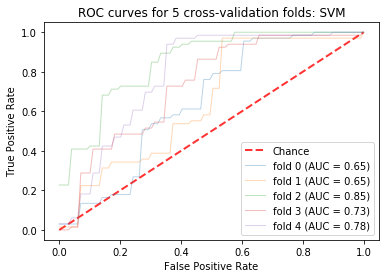

In [11]:
# Plot a ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_SVM, aucs_SVM, 'SVM')

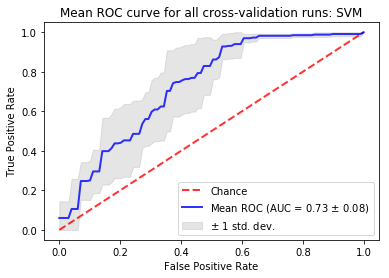

In [12]:
# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_SVM, aucs_SVM, 'SVM')

### Train Naive Bayes

Train the Naive Bayes (`GaussianNB`) Classifier.  Does not need to be configured for probabilistic classification.

In [13]:
NB_classifier = GaussianNB()

accuracies_NB, f1_scores_NB, tprs_NB, aucs_NB, precision_NB, recall_NB = evaluate_classifier(folds=5, 
                                                                                             p=predictors, t=target, 
                                                                                             classifier=NB_classifier, 
                                                                                             mean_fpr=mean_fpr)

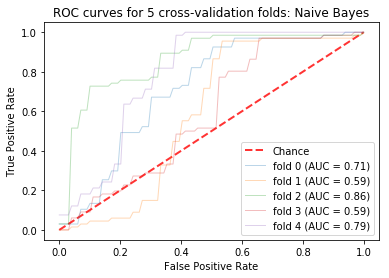

In [14]:
# Plot a ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_NB, aucs_NB, 'Naive Bayes')

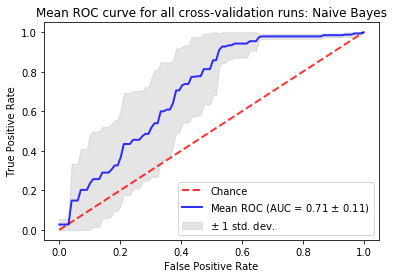

In [15]:
# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_NB, aucs_NB, 'Naive Bayes')

### Train a 3rd scikit-learn Classifier

For this part of Task 1 I've decided to implement the `LogisticRegression` from scikit-learn.  

In [16]:
LR_classifier  = LogisticRegression()

accuracies_LR, f1_scores_LR, tprs_LR, aucs_LR, precision_LR, recall_LR = evaluate_classifier(folds=5, 
                                                                                             p=predictors, t=target, 
                                                                                             classifier=LR_classifier, 
                                                                                             mean_fpr=mean_fpr)

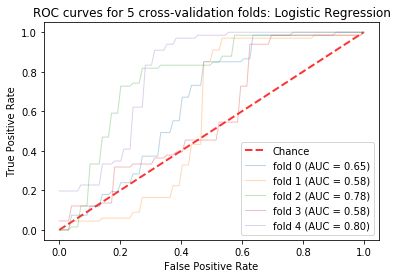

In [17]:
# Plot a ROC curve for each cross-validation fold
plot_roc_cv_folds(mean_fpr, tprs_LR, aucs_LR, 'Logistic Regression')

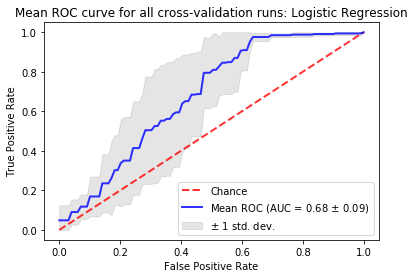

In [18]:
# Plot a mean ROC curve for all cross-validation runs
plot_roc_mean(mean_fpr, tprs_LR, aucs_LR, 'Logistic Regression')

### Compare SVM, Naive Bayes and 3rd Classifier (Logistic Regression)

**Reflection** While I originally didn't include box plots of the accuracy or F1 scores for the classifiers, I added these after completing Task 2 with box plots.  The box plots provided additional insight by helping to visualise the range and variance (in the general sense) of the different metrics.  

-----

Plotting the ROC curve of the classifiers is the first visualation to help compare the models.

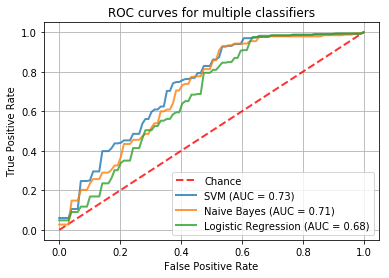

In [19]:
plot_roc_multiple_classifiers(mean_fpr, 
                              np.stack((np.mean(tprs_SVM, axis=0), np.mean(tprs_NB, axis=0), np.mean(tprs_LR, axis=0))), 
                              np.array([np.mean(aucs_SVM), np.mean(aucs_NB), np.mean(aucs_LR)]), 
                              np.array(['SVM', 'Naive Bayes', 'Logistic Regression']))

We then look at accuracy of the different models, which tells us how often the classification was correct.

In [20]:
# Compare the statistics of the accuracies across all cross-validation folds
accuracies_df = pd.DataFrame(data={'SVM' : accuracies_SVM, 'Naive Bayes' : accuracies_NB, 'Logistic Regression' : accuracies_LR})
accuracies_df.describe()

,SVM,Naive Bayes,Logistic Regression
count,5.000000,5.000000,5.000000
mean,0.808403,0.791670,0.808403
std,0.029567,0.053465,0.029567
min,0.778947,0.715789,0.778947
25%,0.783505,0.762887,0.783505
50%,0.812500,0.804124,0.812500
75%,0.814433,0.822917,0.814433
max,0.852632,0.852632,0.852632


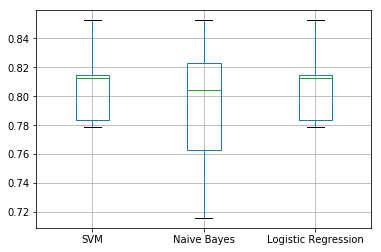

In [21]:
accuracies_df.boxplot()

Next consider the Area Under the Curve (AUC).  As on the plot, the AUC gives an easy comparison of the ROC curves of the models.

In [22]:
auc_df = pd.DataFrame(data={'SVM' : aucs_SVM, 'Naive Bayes' : aucs_NB, 'Logistic Regression' : aucs_LR})
auc_df.describe()

,SVM,Naive Bayes,Logistic Regression
count,5.000000,5.000000,5.000000
mean,0.732107,0.707862,0.677811
std,0.086414,0.119530,0.106168
min,0.648756,0.589055,0.576617
25%,0.650249,0.590909,0.583072
50%,0.729885,0.712935,0.650249
75%,0.782654,0.786311,0.781313
max,0.848990,0.860101,0.797806


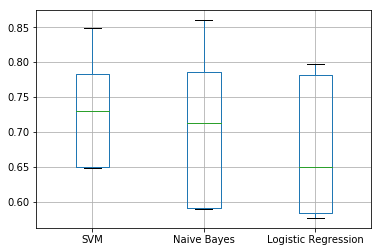

In [23]:
auc_df.boxplot()

Finally we look at F1 scores of the different models.  These scores consider precision and recall and are a better general measure of the predictive power of the algorithm.

In [24]:
# Compare the statistics of the F1-scores across all cross-validation folds
f1_scores_df = pd.DataFrame(data={'SVM' : f1_scores_SVM, 
                                  'Naive Bayes' : f1_scores_NB, 
                                  'Logistic Regression' : f1_scores_LR})

f1_scores_df.describe()

,SVM,Naive Bayes,Logistic Regression
count,5.000000,5.000000,5.000000
mean,0.876278,0.860583,0.876278
std,0.017193,0.036598,0.017193
min,0.860927,0.808511,0.860927
25%,0.860927,0.839161,0.860927
50%,0.878378,0.872483,0.878378
75%,0.878378,0.882759,0.878378
max,0.902778,0.900000,0.902778


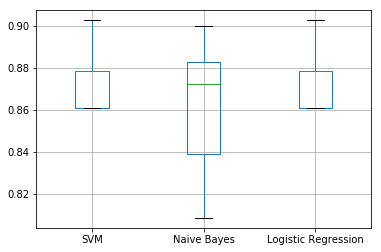

In [25]:
f1_scores_df.boxplot()

### Conclusion

Both `SVM` and `LogisticRegression` have identical values for _accuracy_ and _F1 score_. Investigating would be interesting, but is beyond the scope of this exercise.

The ROC curve and the AUC values suggest that SVM is better than the other algorithms.  The AUC is higher as is the mean accuracy, though not by much.  The ROC curve shows that SVM outperforms the others. In general it achieves a higher Sensitivity (TPR) for a lower FPR.

The F1 Score favours SVM or Logistic Regression.  This measure considers Precision and Recall so is a more predictive metric.  

The Box Plots give a different perspective and also suggest SVM.  The Inter-Quartile range (IQR) of SVM shows lower variance than the others, so it was much more consistent across the CV training.

All of the above suggests that SVM is the better algorithm to take forward for optimisation.


## Task 2


With the modifications to `evaluate_classifier` we now have _precision_ and _recall_ information for each of the models that have been evaluated.


In [26]:
# Compare the precision results across all cross-validation folds
precision_df = pd.DataFrame(data={'SVM' : precision_SVM, 'Naive Bayes' : precision_NB, 'Logistic Regression' : precision_LR})
precision_df.describe()

,SVM,Naive Bayes,Logistic Regression
count,5.000000,5.000000,5.000000
mean,0.793400,0.800727,0.793400
std,0.026854,0.033546,0.026854
min,0.764706,0.760000,0.764706
25%,0.773810,0.789474,0.773810
50%,0.792683,0.792683,0.792683
75%,0.802469,0.810127,0.802469
max,0.833333,0.851351,0.833333


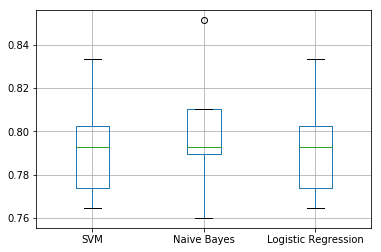

In [27]:
precision_df.boxplot()

In [28]:
# Compare the recall results across all cross-validation folds
recall_df = pd.DataFrame(data={'SVM' : recall_SVM, 'Naive Bayes' : recall_NB, 'Logistic Regression' : recall_LR})
recall_df.describe()

,SVM,Naive Bayes,Logistic Regression
count,5.000000,5.000000,5.000000
mean,0.978969,0.930710,0.978969
std,0.008051,0.048427,0.008051
min,0.970149,0.863636,0.970149
25%,0.970149,0.895522,0.970149
50%,0.984848,0.954545,0.984848
75%,0.984848,0.969697,0.984848
max,0.984848,0.970149,0.984848


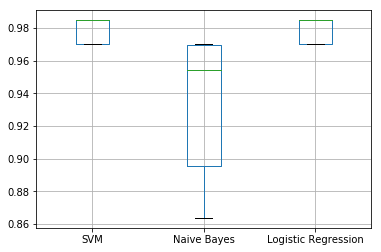

In [29]:
recall_df.boxplot()

### Conclusion

The boxplots for Precision and Recall offer a different view of the models' performance

Naive Bayes offer a marginally higher Precision value (the proportion predicted positives that were correct), however the Recall metric (the proportion of actual positives predicted) is poorer.  The low value for recall indicates that either SVM or Logistic Regression are better choices to take forward.

Depending on the business priority it might be that the Recall value is very important.  For a loan like a mortage that runs over many years, the opportunity cost of a False Negative could be very high.

As both SVM and Logistic Regression have the same Precision-Recall scores, we could take either forward.  As noted earlier, however the better AUC value for SVM gives it an edge, and it will be used in Task 3.

## Task 3

As noted above for this task I've chosen SVM due to the better overall metrics, and low variance in those metrics across the CV folds.

The goal for this task is to minimise the False Postivies.  This means that we are seeking to improve the _Precision_ metric of the model.

To evaluate a number of different parameters, scikit-learn's `GridSearch` capability will be used.  Many of the parameters relate to more specific knowledge of the implmentation than I have.  The following parameters will be checked:

 - Different `kernel` types
 - Different values of `C` to determine the optimum regularisation value to apply
 - For the RBF and Poly kernels, different values of `gamma` to determine the influence of single training examples
 - For the Poly kernel, a number of different degrees along with the previous combinations


In [30]:
# Dictionary of parameters to be assessed as part of GridSearch
param_grid = [
    {'C': np.logspace(-3, 2, 5), 'kernel': ['linear', 'rbf', 'poly']},
    {'C': np.logspace(-3, 2, 5), 'kernel': ['rbf', 'poly'], 'gamma': np.logspace(-3, 2, 5)},
    #{'C': np.logspace(-3, 2, 5), 'kernel': ['poly'], 'degree': [3, 5, 10], 'gamma': np.logspace(-5, 5, 20)}
]

# Create a GridSearch over SVC optimising for Recall using 5 folds as with the original evaluations
grid = GridSearchCV(estimator=svm.SVC(probability=True),
                   param_grid=param_grid,
                   scoring='precision',
                   cv=5)

# Apply fit to execute the search
grid.fit(predictors, target)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'C': array([1.00000e-03, 1.77828e-02, 3.16228e-01, 5.62341e+00, 1.00000e+02]), 'kernel': ['linear', 'rbf', 'poly']}, {'C': array([1.00000e-03, 1.77828e-02, 3.16228e-01, 5.62341e+00, 1.00000e+02]), 'kernel': ['rbf', 'poly'], 'gamma': array([1.00000e-03, 1.77828e-02, 3.16228e-01, 5.62341e+00, 1.00000e+02])}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='precision', verbose=0)

We can use the methods of `GridSearch` to identify the best fit that the model found.

In [32]:
# The best score from the model
previous_best = precision_df['SVM'].mean()
print(f"The best Precision score from the GridSearch is {grid.best_score_}.  The previous best was {previous_best}.\n")

# The optimal parameters for SVM
print(f"The optimum parameters for SVM from the GridSearch are:\n{grid.best_params_}\n")

# The model definition
print(f"The complete constructor for the optimum parameters (including defaults) is:\n{grid.best_estimator_}")

The best Precision score from the GridSearch is 0.7933548259336857.  The previous best was 0.7934001604255072.

The optimum parameters for SVM from the GridSearch are:
{'C': 0.31622776601683794, 'kernel': 'linear'}

The complete constructor for the optimum parameters (including defaults) is:
SVC(C=0.31622776601683794, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


### Conclusion

